# AutoGenU for Jupyter

An Automatic C++ Code Generator for Nonlinear Model Predictive Control (NMPC)  

---  

##  (My memo)
・autogenuNのテスト

・東さんのタンクシステム．


---

# Generate C++ code for optimal control problem (OCP)

## Import module

In [24]:
import autogenu

## Set dimensions and define `AutoGenU`
- `nx`: Dimension of the state vector $x$   
- `nu`: Dimension of the control input vector $u$  
- `ocp_name`: Name of the optimal control problem (OCP). Used as the name of the directory containing the generated C++ source files.

In [25]:
nxo = 2
player = 2
nu = 2
ocp_name = 'tank_two'
ag = autogenu.AutoGenU(ocp_name, nxo, nu, player)

## Generate t, x, and u, necessary variables to formulate of the optimal control problem
- `t`: Time parameter $t$  
- `x`: The state vector $x$  
- `u`: The control input vector $u$  

In [26]:
t = ag.define_t()
x = ag.define_x()
u = ag.define_u()

## Separate u into each player

- How many imput does $i$ th player have? 
- The length of ulist must be equal to $player$
- The sum of number in ulist must be equal to $nu$


In [27]:
ulist = [1,1]
ag.separate_u(ulist)

[1, 1]

## Define variables used in the state equation, constraints, and cost function
- Define a scalar variable whose name is "var" as  
`var = ag.define_scalar_var('var') `

- Define scalar variables whose names are "var\_1", "var\_2", ..., "var\_n" as  
`var_1, var_2, ..., var_n = ag.define_scalar_vars('var_1', 'var_2', ..., 'var_n')`

- Define array variables whose name is "vec" and dimension is dim_vec as  
`vec = ag.define_array_var('vec', dim_vec)`

In [28]:
# Variables used in the state function

# Variables used in the constraints on the control input

# Variables used in the cost function
x1_min, x2_min = ag.define_scalar_vars('x1_min','x2_min')
q1, q2 = ag.define_scalar_vars('q1','q2')
Q1, Q2 = ag.define_scalar_vars('Q1','Q2')
r1, r0, r4= ag.define_scalar_vars('r1','r0', 'r4')
sf1, sf2 = ag.define_scalar_vars('sf1','sf2')

S1, S2 = ag.define_scalar_vars('S1', 'S2')
g, a, b = ag.define_scalar_vars('g' ,'a' , 'b')


## Define the state equation, constraints, the stage cost, and the terminal cost
- `f`: The state equation $ f(t, x, u)$  
- `C`: The equality constraisnts $C(t, x, u) = 0 $  
- `h`: The inequality constraisnts $h(t, x, u) \leq 0$ considered by semi-smooth Fischer-Burumeister method  
- `L`: The stage cost $L(t, x, u)$  
- `phi`: The terminal cost $\phi (t, x)$  

Note: array indices start with 0

In [29]:
# Import symbolic math from sympy. If you need more functions, import same as below.
from sympy import sin, cos, tan, exp, log, sinh, cosh, tanh, diff, sqrt

In [30]:
# Define the state equation
fo = [(u[0] - u[1]*tanh(a*(x[0]-x[1]))*sqrt(2*g*(x[0]-x[1])*tanh(b*(x[0]-x[1]))) -q1)/S1,
      (- u[1]*tanh(a*(x[1]-x[0]))*sqrt(2*g*(x[1]-x[0])*tanh(b*(x[1]-x[0]))) -q2)/S2]


# Define the constraints
C = []

# Define the inequality constraints considered using the semi-smooth Fischer-Burmeister method
h = [x1_min - x[0],
     x2_min - x[1]]

xref1 = 4 ; xref2 = 2 

# Define the stage cost
L1 = Q1*(x[0]-xref1)**2 + r4*(u[0]-(q1+q2))**2 #+ r0/(u[0]**2) #- r1*log(u[1]*(1-u[1])) 
L2 = Q2*(x[1]-xref2)**2 #- r1*log(u[1]*(1-u[1]))

L = [L1, L2]
# Define the terminal cost
phi1 = sf1*(x[0]-xref1)**2
phi2 = sf2*(x[1]-xref2)**2

phi = [phi1, phi2]

In [31]:
# Set functions
ag.set_functions(fo, C, h, L, phi)

## Define the control input bound constraints
The box constraints on the control input $u_{\rm min} \leq u \leq u_{\rm max}$ are treated in a special manner.
Specifically, it is transformed into $$u^2 + u_{\rm dummy}^2 - (\frac{u_{\rm max} - u_{\rm min}}{2})^2 = 0$$.  
Further, $u_{\rm dummy}$ and associated Lagrange multiplier are eliminated in Newton-type iteration efficiently in the multiple-shooting solver.  
Set such box constraints by specifying
- `uindex`: index of the constrained control input element
- `umin`: Minimum value (lower bound) of the control input element
- `umax`: Maximum value (upper bound) of the control input element
- `dummy_weight`: Weight parameter of the dummy (slack) variable

In [32]:
ag.add_control_input_bounds(uindex=0, umin=0.0, umax=5, dummy_weight=0.1)
ag.add_control_input_bounds(uindex=1, umin=0.0, umax=1, dummy_weight=0.1)

## Set Parameters
Set values for all parameters you defined.
- Set `value` for a scalar variable whose name is "var" as  
`ag.set_scalar_var('var', value) `

- Set `value_1`, `value_2`, ..., `value_n`, for scalar variables whose names are "var\_1", "var\_2", ..., "var\_n" as  
`ag.set_scalar_vars(['var_1', value_1], ['var_2', value_2], ..., ['var_n', value_n])`

- Set array variables `var_1`, `var_2`, ..., `var_n` whose name is "vec" and dimension is n as  
`ag.define_array_var('vec', [var_1, var_2, ..., var_n])`

In [33]:
ag.set_scalar_vars(['Q1', 0],['Q2', 10])
ag.set_scalar_vars(['r1', 0.2],['r0', 0.1], ['r4', 1])
ag.set_scalar_vars(['sf1', 5],['sf2', 5])

ag.set_scalar_vars(['q1', 1.5],['q2', 0.5])
ag.set_scalar_vars(['g', 9.78],['a', 0.5] ,['b', 0.2])
ag.set_scalar_vars(['S1', 25],['S2', 25])

ag.set_scalar_vars(['x1_min', 4.5], ['x2_min', 0.0])

#ag.set_array_var('q_terminal', [])
#ag.set_array_var('x_ref', [])

ag.set_FB_epsilon([0.01, 0.01])

## Generate C++ codes of the definition of the optimal control problem
Generate `ocp.hpp` that defines the optimal control problem (OCP).  
- `simplification`: The flag for simplification. If `True`, symbolic functions are simplified. However, if functions are too complicated, it takes too much time. Default is `False`.  
- `common_subexpression_elimination`: The flag for common subexpression elimination. If `True`, common subexpressions in fxu, phix, hx, and hu are eliminated when `ocp.hpp` is generated. Default is `False`. 

In [34]:
simplification = False
common_subexpression_elimination = False

ag.generate_ocp_definition(simplification, common_subexpression_elimination)

'ocp.hpp', the definition of the OCP, is generated at /root/autogenuN01/generated/tank_two


---  
# Generate C++ codes of NMPC solver and numerical simulation  

## Set NLP type  
Set which NLP formulation you use. (hint: `MultipleShooting` works better for typical nonlinear problems.)
- `MultipleShooting` (recommended) : The multiple shooting based C/GMRES method with condensing of the state and the Lagragne multipliers with respect to the state equation.
- `SingleShooting` : The single shooting method, i.e., the original C/GMRES method.

In [35]:
nlp_type = autogenu.NLPType.SingleShooting
ag.set_nlp_type(nlp_type)

## Set horizon length 

- `Tf`, `alpha`: Parameters for the length of the horizon. If $\alpha > 0$, time-varying horizon length $T(t) = T_f (1 - e^{-\alpha t})$ is used. Otherwise, $T(t)$ is fixed by $T_f$. 

In [36]:
Tf = 1.5
alpha = 0.5

ag.set_horizon_params(Tf, alpha)

## Set parameters for the C/GMRES method

- `sampling_time`: Sampling period.
- `N`: The number of the discretization grids of the horzion.  
- `finite_difference_epsilon`: Step length of a finite difference approximations of hessian-vector products in C/GMRES.   
- `zeta`: A stabilization parameter of the C/GMRES method. Basically, must be set by the reciprocal of the sampling time.  
- `kmax`: The maximam number of the iteration of the GMRES.

In [37]:
sampling_time = 0.01
N = 10
finite_difference_epsilon = 1.0e-8
zeta = 100
kmax = 10

ag.set_solver_params(sampling_time, N, finite_difference_epsilon, zeta, kmax)

## Set parameters for the initialization of the solution  
- `solution_initial_guess`: The initial guess of the solution of the optimal control problem (OCP) for initialization of the solution of NMPC.   
- `tolerance`: The residual tolerance of the solution of the OCP for the initialization of the solution of NMPC. The Newton iteration terminates when the optimality error is less than this velue.  
- `max_iterations`: The maxmum number of Newton iteration for the initialization of the solution of NMPC.  

In [38]:
solution_initial_guess = [1.0, 0.5, 0.01, 0.01]
tolerance = 1.0e-06
max_iterations = 0

ag.set_initialization_params(solution_initial_guess, tolerance, max_iterations)

## Set parameters for numerical simulation
- `initial_time`: Initial time of the numerical simulation.  
- `initial_state`: Initial state vector of the system.  
- `simulation_length`: Simulation length.  

In [39]:
initial_time = 0
initial_state_o = [5.0, 3.0]  
simulation_length = 500

ag.set_simulation_params(initial_time, initial_state_o, simulation_length) 

## Generate main.cpp and CMakeLists.txt

In [40]:
ag.generate_main()
ag.generate_cmake()

'main.cpp', the closed-loop simulation code, is generated at /root/autogenuN01/generated/tank_two
CMakeLists.txt are generated at /root/autogenuN01/generated/tank_two/python


## Build and run simulation

- `generator`: An optional variable for Windows user to choose the generator of CMake. If 'MSYS', then 'MSYS Makefiles' is used. If 'MinGW', then 'MinGW Makefiles' is used. The default value is 'Auto' and the generator is selected automatically. If sh.exe exists in your PATH, MSYS is choosed, and otherwise MinGW is used. 
- `vectorize` : If `True`, the vectorization, i.e., `-march=native` compile option is enabled. This can improve speed while can cause numerical issue depending on the compiler.  
- `remove_build_dir`: If `True`, the existing build directory is removed. If `False`, the build directory is not removed. Need to be set `True` if you change the generator. Default is `False`.

In [41]:
generator = 'Auto'  
vectorize = False
remove_build_dir = False
ag.git_submodule_update()
ag.build_main(generator=generator, vectorize=vectorize, remove_build_dir=remove_build_dir)
ag.run_simulation()

Update git submodules...
Successfully updated git submodules

CMake options: -DCMAKE_BUILD_TYPE=Release -DVECTORIZE=OFF -DBUILD_MAIN=ON -DBUILD_PYTHON_INTERFACE=OFF
CMake Deprecation Warning at CMakeLists.txt:5 (cmake_minimum_required):
  Compatibility with CMake < 3.5 will be removed from a future version of
  CMake.

  Update the VERSION argument <min> value or use a ...<max> suffix to tell
  CMake that the project does not need compatibility with older versions.


-- Configuring done (1.2s)
-- Generating done (0.1s)
-- Build files have been written to: /root/autogenuN01/generated/tank_two/build


[ 50%] Building CXX object CMakeFiles/tank_two.dir/main.cpp.o
[100%] Linking CXX executable tank_two
[100%] Built target tank_two


Start a simulation...
End the simulation

MPC used in this simulation:
Single shooting CGMRES solver:
  N:    10
  kmax: 10
OCP_tank_two:
  nx:  4
  nu:  2
  nc:  2
  nh:  2
  nuc: 4
  nub: 2

  x1_min: 4.5
  x2_min: 0
  q1: 1.5
  q2: 0.5
  Q1: 0
  Q2: 10
  r1:

## Plot the simulation results

In [42]:
%matplotlib inline

'created' timestamp seems very low; regarding as unix timestamp
'modified' timestamp seems very low; regarding as unix timestamp
'created' timestamp seems very low; regarding as unix timestamp
'modified' timestamp seems very low; regarding as unix timestamp
'created' timestamp seems very low; regarding as unix timestamp
'modified' timestamp seems very low; regarding as unix timestamp


The graph of the simlation results is generated at /root/autogenuN01/generated/tank_two/log/tank_two.pdf


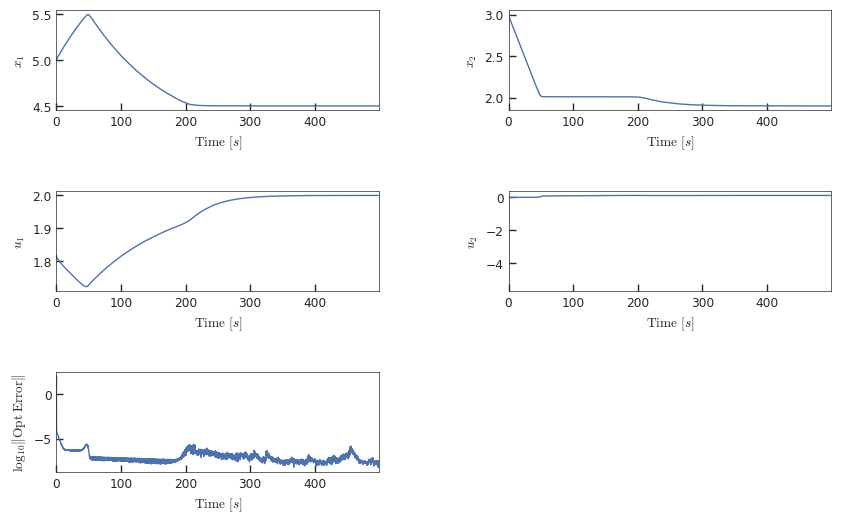

In [43]:
plotter = autogenu.Plotter(log_dir=ag.get_ocp_log_dir(), log_name=ag.get_ocp_name(), player = player)
plotter.set_scales(2,5,2)
# plotter.show()
plotter.save()


## Build Python interface

- `generator`: An optional variable for Windows user to choose the generator of CMake. If 'MSYS', then 'MSYS Makefiles' is used. If 'MinGW', then 'MinGW Makefiles' is used. The default value is 'Auto' and the generator is selected automatically. If sh.exe exists in your PATH, MSYS is choosed, and otherwise MinGW is used. 
- `vectorize` : If `True`, the vectorization, i.e., `-march=native` compile option is enabled. This can improve speed while can cause numerical issue depending on the compiler.  
- `remove_build_dir`: If `True`, the existing build directory is removed. If `False`, the build directory is not removed. Need to be set `True` if you change the generator. Default is `False`.

In [44]:
# generator = 'Auto'  
# vectorize = False
# remove_build_dir = True
# ag.generate_python_bindings()
# ag.git_submodule_update()
# ag.build_python_interface(generator=generator, vectorize=vectorize, remove_build_dir=remove_build_dir)

## Install Python interface

- `install_prefix` : Prefix of the install destination of the python interfaces. Default is None.
    -  If this is None (default), then it is `~/.local/lib/python3.x` (`python3.x` is your Python version). 
        - If you use Ubuntu, `~/.local/lib/python3.x` is the default Python path, and you do not need to set `PYTHONPATH` additonally.  
        - If you use MacOSX or Windows, add it to the Python PATH, as `export PYTHONPATH=$PYTHONPATH:$HOME/.local/lib/python3.x/site-packages`

The usage of Python interfaces is introduced in `examples/python` directory.

In [45]:
# ag.install_python_interface(install_prefix=None)

## Generate Documentation
The documentations for the generated code are available.  
`Doxygen` is required for the docs generation.

In [46]:
# autogenu.generate_docs()
# autogenu.open_docs()